In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import sys

sys.path.insert(0, r"/mnt/c/Users/Trez/Desktop/tudat-bundle/tudatpy/")

In [61]:
# Tudat imports for propagation and estimation
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation

# import MPC interface
from tudatpy.data.mpc import BatchMPC
from tudatpy.data.horizons import HorizonsQuery
from tudatpy.data._biases import get_weights_VFCC17

# import SBDB interface
from tudatpy.data.sbdb import SBDBquery

# other useful modules
import numpy as np
import datetime

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import seaborn as sns
# SPICE KERNELS
spice.load_standard_kernels()

In [62]:
target_mpc_code = 433

observations_start = datetime.datetime(2023, 1, 1)
observations_end = datetime.datetime(2024, 1, 1)

# number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 20 hours for our estimation
timestep_global = 20 * 3600

# 1 month time buffer used to avoid interpolation errors:
time_buffer = 1 * 31 * 86400

# define the frame origin and orientation.
global_frame_origin = "SSB"
global_frame_orientation = "J2000"

target_sbdb = SBDBquery(target_mpc_code)

mpc_codes = [target_mpc_code]  # the BatchMPC interface requires a list.
target_spkid = target_sbdb.codes_300_spkid  # the ID used by the
target_name = target_sbdb.shortname  # the ID used by the

print(f"SPK ID for {target_name} is: {target_spkid}")

SPK ID for 433 Eros is: Eros


In [63]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
    # observatories=["D67"],
    # observatories=["K19"],
    # observatories=["K19", "D67"],
)

batch.set_weights(np.array(list(range(0, batch.size))))
# batch.summary()
print(batch.observatories_table())
print(batch.observatories_table(only_space_telescopes=True))

     Code                                              Name  count
89    089                                          Mykolaiv   35.0
169   169                                Airali Observatory   31.0
678   703                               Catalina Sky Survey   76.0
809   834                                 Buenos Aires-AAAA    2.0
1147  B72                                Soerth Observatory    3.0
1215  C40  Kuban State University Astrophysical Observatory  311.0
1226  C51                                              WISE   40.0
1270  C95         SATINO Remote Observatory, Haute Provence   10.0
1334  D67                    Tula Rooftop Observatory, Tula    6.0
1400  G02            KYSUCE Observatory, Kysucke Nove Mesto   28.0
1415  G17                        BAS Observatory, Scandicci    3.0
1432  G34                                    Oberfrauendorf    3.0
1494  G96                                 Mt. Lemmon Survey   20.0
1767  J69                      North Observatory, Clanfield   

In [64]:
# List the bodies for our environment
bodies_to_create = [
    "Sun",
    "Earth",
]

# Create system of bodies
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation
)

bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve Eros' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch.MPC_objects
central_bodies = [global_frame_origin]

# Full data Custom weights

1990
1910


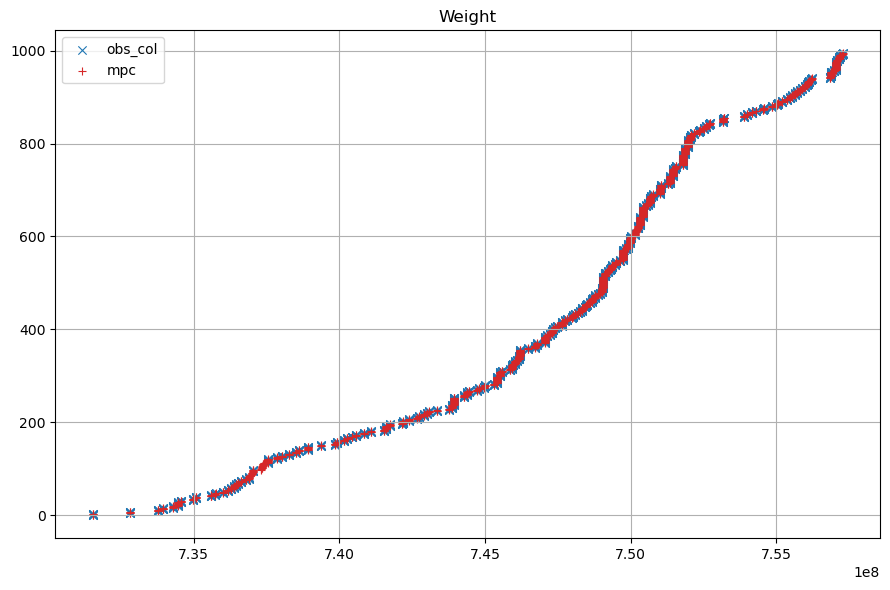

In [65]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
    # observatories=["D67"],
    # observatories=["K19"],
    # observatories=["K19", "D67"],
)

batch.set_weights(np.array(list(range(0, batch.size))))

observation_collection = batch.to_tudat(
    bodies=bodies,
    included_satellites=None,
    apply_star_catalog_debias=True,
    apply_weights_VFCC17=True,
)


fig1, ax = plt.subplots(1, 1, figsize=(9, 6))
temp = batch.table.query("note2 != 's'")
ax.scatter(
    observation_collection.concatenated_times,
    observation_collection.concatenated_weights,
    marker="x",
    linewidth=0.8,
    label="obs_col",
)

table_weights = np.ravel(
    [batch.table.weight.to_list(), batch.table.weight.to_list()], "F"
)
ax.scatter(
    temp.epochJ2000secondsTDB,
    temp.weight,
    marker="+",
    color="tab:red",
    linewidth=0.8,
    label="mpc",
)

ax.grid()
ax.legend()
ax.set_title("Weight")
fig1.set_tight_layout(True)


print(len(table_weights))
print(len(observation_collection.concatenated_weights))
# print(table_weights.astype(np.float32))
# print(np.array(observation_collection.concatenated_weights))

plt.show()

# Full data Real Weights

1910
1910
0.0


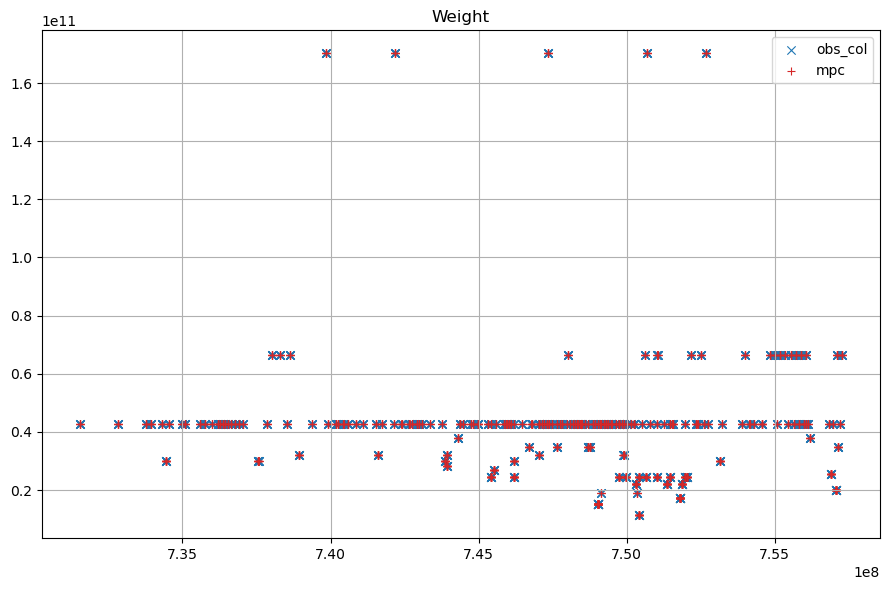

In [75]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
    observatories_exclude=["C51"],
)

observation_collection = batch.to_tudat(
    bodies=bodies,
    included_satellites=None,
    apply_star_catalog_debias=True,
    apply_weights_VFCC17=True,
)

fig1, ax = plt.subplots(1, 1, figsize=(9, 6))
temp = batch.table.query("note2 != 's'")
ax.scatter(
    observation_collection.concatenated_times,
    observation_collection.concatenated_weights,
    marker="x",
    linewidth=0.8,
    label="obs_col",
)


temp_table = batch._table.sort_values(["observatory", "epochJ2000secondsTDB"], ascending=True)

table_weights = np.ravel(
    [temp_table.weight.to_numpy(), temp_table.weight.to_numpy()], "F"
)
table_times = np.ravel(
    [temp_table.epochJ2000secondsTDB.to_numpy(), temp_table.epochJ2000secondsTDB.to_numpy()], "F"
)
ax.scatter(
    table_times,
    table_weights,
    marker="+",
    color="tab:red",
    linewidth=0.8,
    label="mpc",
)
# table_weights = np.ravel(
#     [batch.table.weight.to_list(), batch.table.weight.to_list()], "F"
# )
# ax.scatter(
#     temp.epochJ2000secondsTDB,
#     temp.weight,
#     marker="+",
#     color="tab:red",
#     linewidth=0.8,
#     label="mpc",
# )

ax.grid()
ax.legend()
ax.set_title("Weight")
fig1.set_tight_layout(True)


print(len(table_weights))
print(len(observation_collection.concatenated_weights))
if len(table_weights) == len(observation_collection.concatenated_weights):
    print(np.sum(table_weights - np.array(observation_collection.concatenated_weights)))
else:
    print("lengths dont match")
plt.show()

# One observatory

254
254
0.0


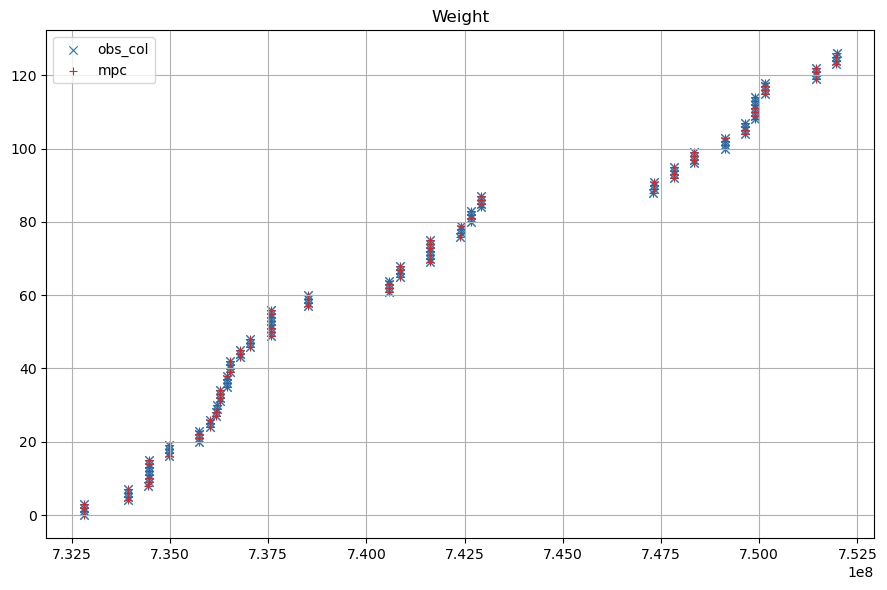

In [74]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
    # observatories=["D67"],
    observatories=["M22"],
    # observatories=["K19"],
    # observatories=["K19", "D67"],
)

batch.set_weights(np.array(list(range(0, batch.size))))

observation_collection = batch.to_tudat(
    bodies=bodies,
    included_satellites=None,
    apply_star_catalog_debias=True,
    apply_weights_VFCC17=True,
)


fig1, ax = plt.subplots(1, 1, figsize=(9, 6))
temp = batch.table.query("note2 != 's'")
ax.scatter(
    observation_collection.concatenated_times,
    observation_collection.concatenated_weights,
    marker="x",
    linewidth=0.8,
    label="obs_col",
)

table_weights = np.ravel(
    [batch.table.weight.to_list(), batch.table.weight.to_list()], "F"
)
ax.scatter(
    temp.epochJ2000secondsTDB,
    temp.weight,
    marker="+",
    color="tab:red",
    linewidth=0.8,
    label="mpc",
)

ax.grid()
ax.legend()
ax.set_title("Weight")
fig1.set_tight_layout(True)


print(len(table_weights))
print(len(observation_collection.concatenated_weights))
print(np.sum(table_weights - np.array(observation_collection.concatenated_weights)))
plt.show()

# One observation

2
2
0.0


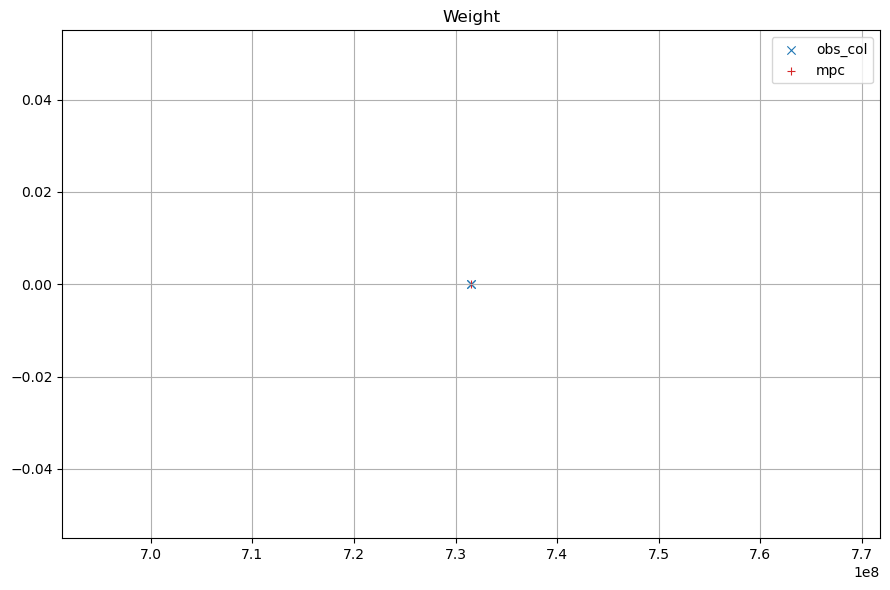

In [68]:
batchtemp = BatchMPC()
batchtemp.get_observations(mpc_codes)
batchtemp.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
)
batch = BatchMPC()
batch.from_pandas(batchtemp.table.iloc[0:1])
# print(batch.table)
batch.set_weights(np.array(list(range(0, batch.size))))

observation_collection = batch.to_tudat(
    bodies=bodies,
    included_satellites=None,
    apply_star_catalog_debias=True,
    apply_weights_VFCC17=True,
)


fig1, ax = plt.subplots(1, 1, figsize=(9, 6))
temp = batch.table.query("note2 != 's'")
ax.scatter(
    observation_collection.concatenated_times,
    observation_collection.concatenated_weights,
    marker="x",
    linewidth=0.8,
    label="obs_col",
)

table_weights = np.ravel(
    [batch.table.weight.to_list(), batch.table.weight.to_list()], "F"
)
ax.scatter(
    temp.epochJ2000secondsTDB,
    temp.weight,
    marker="+",
    color="tab:red",
    linewidth=0.8,
    label="mpc",
)

ax.grid()
ax.legend()
ax.set_title("Weight")
fig1.set_tight_layout(True)


print(len(table_weights))
print(len(observation_collection.concatenated_weights))
# print(table_weights.astype(np.float32))
# print(np.array(observation_collection.concatenated_weights))

print(
    np.sum(
        table_weights.astype(np.float32)
        - np.array(observation_collection.concatenated_weights)
    )
)

plt.show()

# multiple stations, with custom weights

100
100
0.0


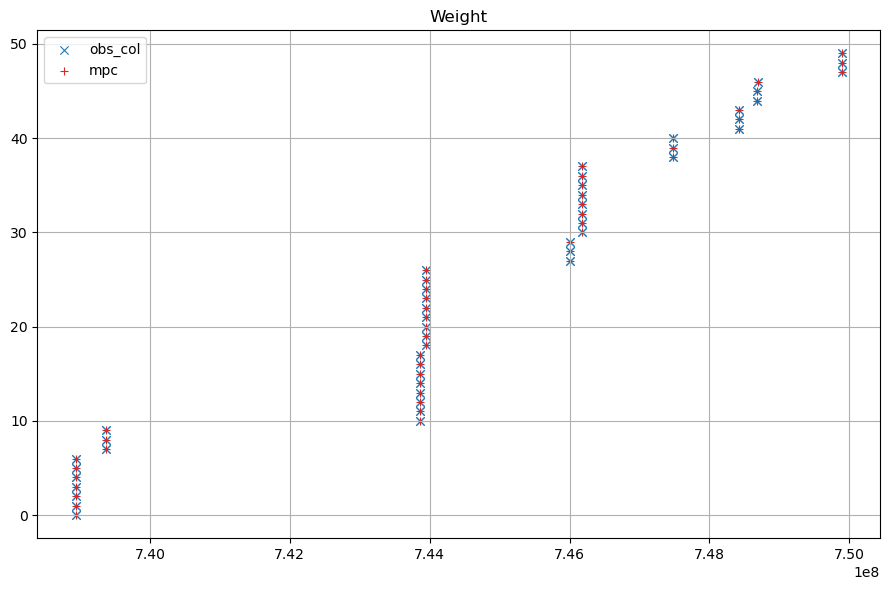

In [69]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
    # observatories=["D67"],
    # observatories=["K19"],
    observatories=[
        "K19",
        "D67",
        # "W68",
        # "M22",
        "089",
        "706",
    ],
)

batch.set_weights(np.array(list(range(0, batch.size))))

observation_collection = batch.to_tudat(
    bodies=bodies,
    included_satellites=None,
    apply_star_catalog_debias=True,
    apply_weights_VFCC17=True,
)


fig1, ax = plt.subplots(1, 1, figsize=(9, 6))
temp = batch.table.query("note2 != 's'")
ax.scatter(
    observation_collection.concatenated_times,
    observation_collection.concatenated_weights,
    marker="x",
    linewidth=0.8,
    label="obs_col",
)

table_weights = np.ravel(
    [batch.table.weight.to_list(), batch.table.weight.to_list()], "F"
)
ax.scatter(
    temp.epochJ2000secondsTDB,
    temp.weight,
    marker="+",
    color="tab:red",
    linewidth=0.8,
    label="mpc",
)

ax.grid()
ax.legend()
ax.set_title("Weight")
fig1.set_tight_layout(True)


print(len(table_weights))
print(len(observation_collection.concatenated_weights))
# print(table_weights.astype(np.float32))
# print(np.array(observation_collection.concatenated_weights))
print(
    np.sum(
        table_weights.astype(np.float32)
        - np.array(observation_collection.concatenated_weights)
    )
)
plt.show()

# multiple stations, no custom weights

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
100
100
-43350.011459350586


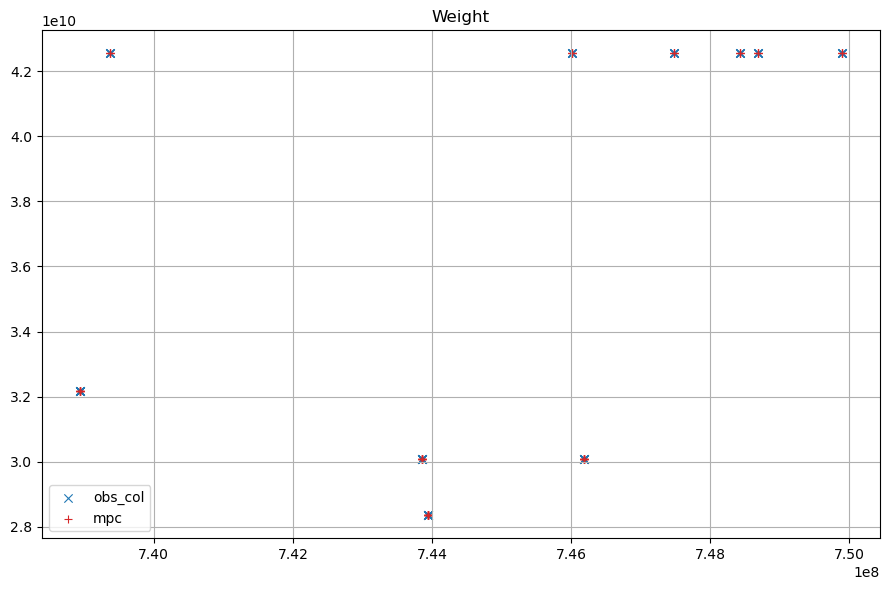

In [71]:
batch = BatchMPC()
batch.get_observations(mpc_codes)
batch.filter(
    epoch_start=observations_start,
    epoch_end=observations_end,
    # observatories=["D67"],
    # observatories=["K19"],
    observatories=[
        "K19",
        "D67",
        # "W68",
        # "M22",
        "089",
        "706",
    ],
)

# batch.set_weights(np.array(list(range(0, batch.size))))

observation_collection = batch.to_tudat(
    bodies=bodies,
    included_satellites=None,
    apply_star_catalog_debias=True,
    apply_weights_VFCC17=True,
)


fig1, ax = plt.subplots(1, 1, figsize=(9, 6))
# temp = batch.table.query("note2 != 's'")
ax.scatter(
    observation_collection.concatenated_times,
    observation_collection.concatenated_weights,
    marker="x",
    linewidth=0.8,
    label="obs_col",
)

temp_table = batch._table.sort_values(["observatory", "epochJ2000secondsTDB"], ascending=True)

table_weights = np.ravel(
    [temp_table.weight.to_numpy(), temp_table.weight.to_numpy()], "F"
)
table_times = np.ravel(
    [temp_table.epochJ2000secondsTDB.to_numpy(), temp_table.epochJ2000secondsTDB.to_numpy()], "F"
)
ax.scatter(
    table_times,
    table_weights,
    marker="+",
    color="tab:red",
    linewidth=0.8,
    label="mpc",
)
# ax.scatter(
#     temp.epochJ2000secondsTDB,
#     temp.weight,
#     marker="+",
#     color="tab:red",
#     linewidth=0.8,
#     label="mpc",
# )

ax.grid()
ax.legend()
ax.set_title("Weight")
fig1.set_tight_layout(True)

# print(list(table_weights))
# print(observation_collection.concatenated_weights)
# print((table_times))
# print(observation_collection.concatenated_times)
print(table_times - np.array(observation_collection.concatenated_times))

print(len(table_weights))
print(len(observation_collection.concatenated_weights))
# print(table_weights.astype(np.float32))
# print(np.array(observation_collection.concatenated_weights))
print(
    np.sum(
        table_weights.astype(np.float32)
        - np.array(observation_collection.concatenated_weights)
    )
)
plt.show()